In [ ]:
!pip3 install nltk
!pip3 install spark
!pip3 install spacy==2.2.4
!pip3 install -U gensim

from collections import Counter, defaultdict

import matplotlib.pyplot as plt  # basic plotting
import nltk #NLP tasks
import numpy as np  # numerical computation
import pandas as pd  # for handling and cleaning data
import plotly.express as px
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

import gensim #for topic modelling
from gensim import corpora

nltk.download('stopwords')
stop=set(stopwords.words('english'))

     |████████████████████████████████| 41 kB 71 kB/s 
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58762 sha256=b34b2256a6122fe1204191fa2b97ca857b4cc40812655bf5707cd5d50be9561b
  Stored in directory: /root/.cache/pip/wheels/4e/0e/f1/164619f9920fb447d294afaae11a7715bd442ded7225953d72
Successfully built spark
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nike  = pd.read_csv("https://s3.amazonaws.com/peyck.es/BDA_Project/oct18-oct19.csv",encoding='')
nike.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,4/1/19 0:00,SneakerShouts,NaN,0,2,24,STEAL: Over 50% OFF + free shipping on the Nik...,NaN,NaN,NaN,1.110000e+18,https://twitter.com/SneakerShouts/status/11125...
1,4/1/19 0:00,Ebay_Birmingham,NaN,0,0,0,Check out #Nike Dry Fit Shorts Women's Tempo N...,NaN,@eBay,#Nike #Nike #ebay #poshmark #mercari,1.110000e+18,https://twitter.com/Ebay_Birmingham/status/111...
2,4/1/19 0:00,SneakerNews,NaN,2,15,102,"The Nike Air Max 97 ""Seoul"" will release via N...",NaN,NaN,NaN,1.110000e+18,https://twitter.com/SneakerNews/status/1112504...
3,4/1/19 0:00,titoloshop,NaN,0,0,0,Nike Air Vapormax Flyknit 3 - Atmosphere Grey/...,NaN,NaN,NaN,1.110000e+18,https://twitter.com/titoloshop/status/11125048...
4,4/1/19 0:00,Taniabanks24,BornLiveDieFree,2,0,0,@MichaelAvenatti He ain‚Äôt dumb he is not sho...,NaN,@MichaelAvenatti,NaN,1.110000e+18,https://twitter.com/Taniabanks24/status/111250...


In [ ]:
nike.shape

(4430893, 12)

In [ ]:
nike.text.describe()


count     4430893
unique    4025865
top          Nike
freq        15050
Name: text, dtype: object

In [ ]:
nike.text.map(lambda x: isinstance(x, float)).value_counts()

False    4430893
Name: text, dtype: int64

In [ ]:
print('Dataset size:',nike.shape)
print('Columns are:',nike.columns)

Dataset size: (4430893, 12)
Columns are: Index(['date', 'username', 'to', 'replies', 'retweets', 'favorites', 'text',
       'geo', 'mentions', 'hashtags', 'id', 'permalink'],
      dtype='object')


In [ ]:
nike.dtypes

date          object
username      object
to            object
replies        int64
retweets       int64
favorites      int64
text          object
geo          float64
mentions      object
hashtags      object
id           float64
permalink     object
dtype: object

In [ ]:
def missing_value_of_data(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/ data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])


missing_value_of_data(nike)

,Total,Percentage
geo,4430893,100.00
mentions,3383080,76.35
hashtags,3299590,74.47
to,2984178,67.35
username,1,0.00
date,0,0.00
replies,0,0.00
retweets,0,0.00
favorites,0,0.00
text,0,0.00


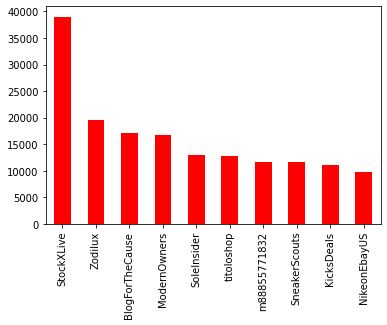

In [ ]:
#which users tweeted the most
users = nike['username'].value_counts()[:10]
users.plot(kind='bar', color='red')

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Let us create a corpus for words(text)
corpus = []

word = nike['text'].str.split()
new = word.values.tolist()
corpus=[word for i in new for word in i]

<BarContainer object of 23 artists>

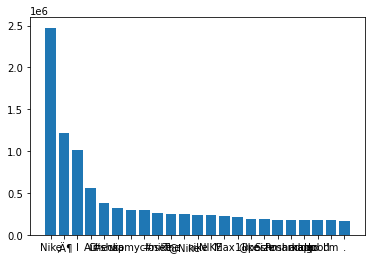

In [ ]:
from collections import Counter

counter=Counter(corpus)
most=counter.most_common(100)

x, y= [], []
for word,count in most[:50]:
    # can avoid stop words too
    if word not in stop:
        x.append(word)
        y.append(count)
        
plt.bar(x,y)

In [ ]:
import plotly.express as px

temp = pd.DataFrame(most)


fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words')
fig.show()

<BarContainer object of 10 artists>

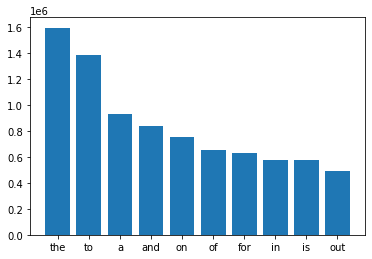

In [ ]:
from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, )

In [ ]:
temp = pd.DataFrame(top)
fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words in stop word list')
fig.show()

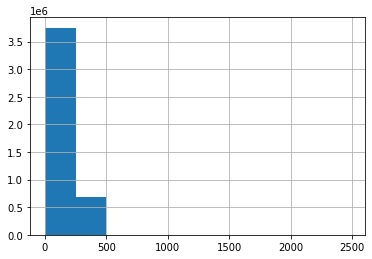

In [ ]:
#length of tweets

nike['text'].str.len().hist()

In [ ]:
min(nike['text'].str.len()), max(nike['text'].str.len())

(4, 2479)

In [ ]:
#range of length of text
nike['text'].str.split().map(lambda x: len(x)).hist()


In [ ]:
min(nike['text'].str.split().map(lambda x: len(x))), max(nike['text'].str.split().map(lambda x: len(x)))


In [ ]:
#average word lenth duration
#nike['text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()


In [ ]:
avg = nike['text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
avg.value_counts()

In [ ]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def get_top_word_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_word_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_word_bigrams(nike['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_trigrams=get_top_word_trigrams(nike['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [ ]:
# lemmatization and stemming

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

copy_df = df.copy()
# taking a fraction of dataset because lemmatization takes a lot of time
nike = nike.sample(frac=0.1)

In [ ]:
def preprocess_corpus(df):
    corpus = []
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    
    for tweet in df['text']:
        tweets = [t for t in word_tokenize(tweet) if (t not in stop)]
        tweets = [lem.lemmatize(t) for t in tweets if len(t)>2]
        corpus.append(tweets)
        
    return corpus

corpus = preprocess_corpus(nike)

In [ ]:
from gensim import corpora
import gensim

dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

In [ ]:
import pyLDAvis.gensim

In [ ]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [ ]:
plot_lda_vis(lda_model, bow_corpus, dic)

In [ ]:
from nlp_profiler_class import NLPProfiler 
new = nike.sample(n=1000)

In [ ]:
%%timeit
profiled_text_dataframe = NLPProfiler().apply_text_profiling(new, 'text')


In [ ]:
profiled_text_dataframe.head(15)